In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:

def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T
        
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)

In [3]:
def lstm_iterator(raw_data, num_steps, data_size):
  batch_size=1
 
  raw_data = np.array(raw_data, dtype=np.float32)

  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len, data_size], dtype=np.float32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1),:]

  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x[0], y[0])

In [4]:
'''symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)'''

"symbol_list = ['C', 'GS']\nrets = get_data(symbol_list)\nins, outs = sort_data(rets)\nins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])\ndiv = int(.8 * ins.shape[0])\ntrain_ins, train_outs = ins[:div], outs[:div]\ntest_ins, test_outs = ins[div:], outs[div:]\n\n#normalize inputs\ntrain_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)"

In [5]:
#sess = tf.InteractiveSession()

In [4]:
class LSTMModel(object):
    def __init__(self, num_steps, num_samples):#, config):
        symbol_list = ['C', 'GS']

        positions = tf.constant([-1,0,1]) #long, neutral or short
        num_positions = 3
        num_symbols = len(symbol_list)
        self.num_samples = num_samples
        self.num_steps = num_steps

        #n_input = num_symbols * 100

        hidden_size=21
        n_classes = num_positions * num_symbols

        #self.num_steps = tf.placeholder(tf.int64)

        # define placeholders 
        self.inputs_ = tf.placeholder(tf.float32, [None, num_symbols])
        self.targets_ = tf.placeholder(tf.float32, [None,  num_symbols])

        cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias=0.0)
        #cell = tf.nn.rnn_cell.MultiRNNCell([cell] * config.num_layers)
        cell = tf.nn.rnn_cell.InputProjectionWrapper(cell,  num_symbols)
        cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell, n_classes)


        outputs=[]
        self.initial_state = cell.zero_state(1, tf.float32)
        state = self.initial_state
        time_step = 0
        
        '''with tf.variable_scope("RNN"):
            def body(x):
                inp = self.inputs_[time_step,:]
                inp = tf.reshape(inp, [1,-1])
                (cell_output, state) = cell(inp, state)
                outputs.append(cell_output)
                return 

            def condition(x):
                return tf.reduce_sum(x) < 100
        
            tf.while_loop(condition, body, [x])'''
            
        with tf.variable_scope("RNN"):
            for time_step in range(self.num_steps):   #####num_steps???
                if time_step > 0: tf.get_variable_scope().reuse_variables()    
                inp = self.inputs_[time_step,:]
                inp = tf.reshape(inp, [1,-1])
                (cell_output, state) = cell(inp, state)
                outputs.append(cell_output) #[6,]

        self.final_state = state 

        y = tf.reshape(tf.concat(1, outputs), [-1, n_classes])





        # loop through symbol, taking the columns for each symbol's bucket together
        pos = {}
        sample_n = {}
        sample_mask = {}
        symbol_returns = {}
        relevant_target_column = {}
        for i in range(num_symbols):
            # isolate the buckets relevant to the symbol and get a softmax as well
            symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
            symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
            # sample probability to chose our policy's action
            sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)
            for sample_iter in range(num_samples):
                sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
                pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
                symbol_returns[i*num_samples + sample_iter] = tf.mul(
                                                                    tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                                     self.targets_[:,i])

                sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
                relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                            symbol_probs * sample_mask[i*num_samples + sample_iter],1)



        daily_returns_by_symbol_ = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
        daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
        daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]

        total_return = tf.reduce_prod(daily_returns+1, 0)
        z = tf.ones_like(total_return) * -1
        self.total_return = total_return = tf.add(total_return, z)


        ann_vol = tf.mul(
            tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
            np.sqrt(252)
            )
        self.sharpe = tf.div(total_return, ann_vol)
        #Maybe metric slicing later
        #segment_ids = tf.ones_like(daily_returns[:,0])
        #partial_prod = tf.segment_prod(daily_returns+1, segment_ids)


        training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
        ones = tf.ones_like(training_target_cols)
        gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

        gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

        #cost = tf.mul(gradient , daily_returns_by_symbol_reshaped)
        #cost = tf.mul(gradient , tf.expand_dims(daily_returns, -1))
        cost = tf.mul(gradient , tf.expand_dims(total_return, -1))
        #cost = tf.mul(gradient , tf.expand_dims(sharpe, -1))

        self.optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
        self.costfn = tf.reduce_mean(cost)

In [5]:
def run_train_results(m, epoch):
    state = m.initial_state.eval()
    full_feed = {m.inputs_: rets[:-1], m.targets_: rets[1:], m.initial_state: state}
    
    t,s, c = session.run([ m.total_return, m.sharpe, m.costfn], feed_dict=full_feed)
    t = np.mean(t)
    s = np.mean(s)
    print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
         "sharpe=", "{:.9f}".format(s))

In [6]:
def run_epoch(m, epoch):
    
    full_feed = {m.inputs_: rets[:-1], m.targets_: rets[1:]}
    state = m.initial_state.eval()
    for step, (x, y) in enumerate(lstm_iterator(rets,20,2 )):
        #m.num_steps = len(x)
        feed_dict = {m.inputs_: x, m.targets_: y, m.initial_state: state}
        _ , state = session.run([m.optimizer, m.final_state], feed_dict=feed_dict)
        
    '''if (epoch+1)%2== 0:
        t,s, c = session.run([ m.total_return, m.sharpe, m.costfn], feed_dict=feed_dict)#full_feed)#.reshape(1,-1).T})
        t = np.mean(t)
        s = np.mean(s)
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))'''

In [8]:
with tf.Graph().as_default(), tf.Session() as session:
    # initialize variables to random values
    #init = tf.initialize_all_variables()
    #sess.run(init)
    # run optimizer on entire training data set many times
    #train_size = train_ins.shape[0]
    with tf.variable_scope("model", reuse=None):#, initializer=init):
        m = LSTMModel(num_steps = 20, num_samples = 5)#, config=config)
    with tf.variable_scope("model", reuse=True):#, initializer=init):
        mvalid = LSTMModel(num_steps = len(rets) -1, num_samples = 1)#, config=config)
    tf.initialize_all_variables().run()
    for epoch in range(10):
        #start = rng.randint(train_size-50)
        #batch_size = rng.randint(2,25)
        #end = min(train_size, start+batch_size)

        run_epoch(m, epoch )
        print('getting results...')
        run_train_results(mvalid, epoch)
        '''sess.run(optimizer, feed_dict={inputs_: train_ins[start:end], targets_: train_outs[start:end]})#.reshape(1,-1).T})
        # every 1000 iterations record progress
        if (epoch+1)%100== 0:
            t,s, c = sess.run([ total_return, sharpe, costfn], feed_dict={inputs_: train_ins, targets_: train_outs})#.reshape(1,-1).T})
            t = np.mean(t)
            s = np.mean(s)
            print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
                 "sharpe=", "{:.9f}".format(s))
            #print(t)'''

getting results...
Epoch: 0001 cost= -0.50711 total return= -0.731922448 sharpe= -2.518890381
getting results...
Epoch: 0002 cost= -0.479199 total return= -0.690995097 sharpe= -2.211014509
getting results...
Epoch: 0003 cost= 0.802528 total return= 1.158372164 sharpe= 4.109907150
getting results...
Epoch: 0004 cost= -0.504468 total return= -0.728531718 sharpe= -2.387005329
getting results...
Epoch: 0005 cost= -0.607678 total return= -0.877253473 sharpe= -2.718842506
getting results...
Epoch: 0006 cost= 0.449566 total return= 0.648839116 sharpe= 2.242624998
getting results...
Epoch: 0007 cost= 0.223947 total return= 0.323118806 sharpe= 0.947408140
getting results...
Epoch: 0008 cost= 0.29168 total return= 0.421271563 sharpe= 1.259648323
getting results...
Epoch: 0009 cost= -0.353979 total return= -0.511379957 sharpe= -1.703359842
getting results...
Epoch: 0010 cost= -0.383745 total return= -0.553670168 sharpe= -1.732698441


In [9]:
state.eval

<bound method Tensor.eval of <tf.Tensor 'RNN/BasicLSTMCell_19/concat:0' shape=(1, 42) dtype=float32>>

In [16]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([daily_returns, pos[0]], feed_dict=feed_dict)

In [16]:
x_

array([[-0.02278614, -0.01349073],
       [ 0.01645574,  0.00046793],
       [-0.06229091, -0.03424059],
       [-0.02301918,  0.00290978],
       [-0.01444814, -0.00732817],
       [ 0.        , -0.00972121],
       [ 0.00513662,  0.00950007],
       [ 0.03661115,  0.02413904],
       [-0.00243609,  0.01114777],
       [-0.00534623, -0.00740445],
       [-0.0391589 , -0.01933518],
       [ 0.00744369,  0.0029232 ],
       [ 0.0018748 ,  0.00951207],
       [ 0.00845272,  0.00980073],
       [-0.01468148, -0.01574339],
       [-0.01610275, -0.03067165],
       [-0.00137798,  0.00831226],
       [ 0.00504581,  0.01337255],
       [ 0.02328266,  0.00077818],
       [ 0.0101487 ,  0.00700935]], dtype=float32)

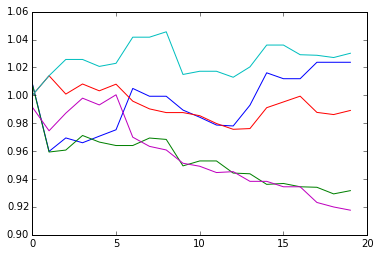

In [17]:
# equity curve
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

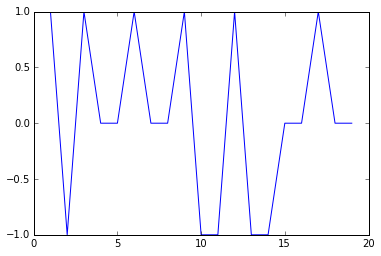

In [18]:
plot(t)

In [66]:
#out of sample results
d, t = sess.run([daily_returns, total_return], feed_dict={x: test_ins, y_: test_outs})

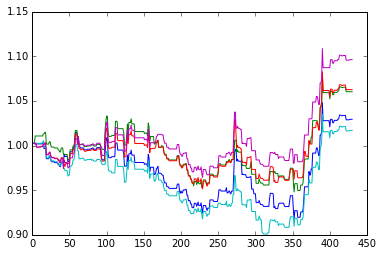

In [67]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))